In [1]:
import torch
import torchvision

import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import vgg19
from torchvision.transforms import Normalize
from torch.optim.lr_scheduler import ExponentialLR

from tqdm import tqdm
import numpy as np

import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings('ignore')

device='cuda' if torch.cuda.is_available() else 'cpu'

print(f'Using: {device}')

Using: cuda


In [2]:
class SRDataset(Dataset):
    """Dataset for the SR GAN, prepares high-res and low-res image pairs for training."""

    def __init__(self, image_dir, hr_image_size):
        """
        Initializes the dataset.
        Args:
            image_dir: The path to the directory containing high resolution images.
            hr_image_size: Integer, the crop size of the images to train on (High
                           resolution images will be cropped to this width and height).
        """
        self.image_paths = [os.path.join(image_dir, x) for x in os.listdir(image_dir) if x.endswith(('jpg', 'jpeg', 'png'))]
        self.image_size = hr_image_size
        self.transform = transforms.Compose([
            transforms.RandomCrop((384,384)),
            transforms.ToTensor()
        ])
        self.to_tensor = transforms.ToTensor()

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')

        if image.size[0] < self.image_size or image.size[1] < self.image_size:
            image = image.resize((self.image_size, self.image_size), Image.BICUBIC)

        high_res = self.transform(image)
        low_res = transforms.functional.resize(high_res, (self.image_size // 4, self.image_size // 4), Image.BICUBIC)
        
        # Rescale the pixel values to the -1 to 1 range
        high_res = high_res * 2.0 - 1.0

        return low_res, high_res

def get_dataloader(image_dir, hr_image_size, batch_size, num_workers=4):
    """
    Returns a PyTorch DataLoader with specified mappings.
    Args:
        image_dir: The path to the directory containing high resolution images.
        hr_image_size: Integer, the crop size of the images to train on.
        batch_size: Int, The number of elements in a batch returned by the dataloader.
        num_workers: Int, CPU threads to use for multi-threaded operation.
    Returns:
        dataloader: A PyTorch DataLoader object.
    """
    dataset = SRDataset(image_dir, hr_image_size)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True, pin_memory=True)

    return dataloader


In [3]:
train_loader=get_dataloader('../../coco_sample/train_sample/',384,8)
test_loader=get_dataloader('../../Flickr2K_Complete/Flickr2K_2/',384,8)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([8, 3, 96, 96]) torch.Size([8, 3, 384, 384])


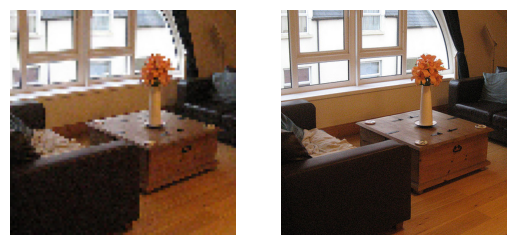

In [4]:
x,y=next(iter(train_loader))
print(x.shape,y.shape)
plt.subplot(1,2,1)
plt.axis(False)
plt.imshow(x[0].permute(1,2,0))
plt.subplot(1,2,2)
plt.axis(False)
plt.imshow(((y[0]+1)/2).permute(1,2,0))

### Model

In [5]:
class FastSRGAN(nn.Module):
    """SRGAN for fast super resolution."""

    def __init__(self):
        super().__init__()

        self.hr_size = 384
        self.lr = 0.0001

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.hr_height = self.hr_size
        self.hr_width = self.hr_size
        self.lr_height = self.hr_height // 4  # Low resolution height
        self.lr_width = self.hr_width // 4  # Low resolution width
        self.lr_shape = (3, self.lr_height, self.lr_width)
        self.hr_shape = (3, self.hr_height, self.hr_width)
        self.iterations = 0

        self.n_residual_blocks = 6

        self.vgg = self.build_vgg().to(self.device)
        self.vgg.eval()
        self.vgg_transforms = torchvision.models.VGG19_Weights.IMAGENET1K_V1.transforms()

        patch = int(self.hr_height / 2 ** 4)
        self.disc_patch = (1, patch, patch)

        self.gf = 32
        self.df = 32

        self.discriminator = self.build_discriminator().to(self.device)
        self.generator = self.build_generator().to(self.device)

        self.GANcriterion = nn.BCEWithLogitsLoss()
        self.MSELoss = nn.MSELoss()

        self.gen_optimizer = torch.optim.Adam(self.generator.parameters(), lr=self.lr, betas=(0.9, 0.999))
        self.disc_optimizer = torch.optim.Adam(self.discriminator.parameters(), lr=self.lr, betas=(0.9, 0.999))

        self.gen_schedule = ExponentialLR(self.gen_optimizer, gamma=0.1, last_epoch=-1)
        self.disc_schedule = ExponentialLR(self.disc_optimizer, gamma=0.1, last_epoch=-1)

    def content_loss(self, hr, sr):
        sr = self.vgg_transforms(sr)
        hr = self.vgg_transforms(hr)
        sr_features = self.vgg(sr) / 12.75
        hr_features = self.vgg(hr) / 12.75
        return F.mse_loss(hr_features, sr_features)

    def build_vgg(self):
        vgg = vgg19(pretrained=True).features
        for param in vgg.parameters():
            param.requires_grad = False

        model = nn.Sequential(*list(vgg.children())[:36])
        return model

    def build_generator(self):
        class ResidualBlock(nn.Module):
            def __init__(self, in_channels, out_channels, expansion=6, stride=1, alpha=1.0):
                super(ResidualBlock, self).__init__()
                self.expansion = expansion
                self.stride = stride
                self.in_channels = in_channels
                self.out_channels = int(out_channels * alpha)
                self.pointwise_conv_filters = self._make_divisible(self.out_channels, 8)
                self.conv1 = nn.Conv2d(in_channels, in_channels * expansion, kernel_size=1, stride=1, padding=0, bias=True)
                self.bn1 = nn.BatchNorm2d(in_channels * expansion)
                self.conv2 = nn.Conv2d(in_channels * expansion, in_channels * expansion, kernel_size=3, stride=stride, padding=1, groups=in_channels * expansion, bias=True)
                self.bn2 = nn.BatchNorm2d(in_channels * expansion)
                self.conv3 = nn.Conv2d(in_channels * expansion, self.pointwise_conv_filters, kernel_size=1, stride=1, padding=0, bias=True)
                self.bn3 = nn.BatchNorm2d(self.pointwise_conv_filters)
                self.relu = nn.ReLU(inplace=True)
                self.skip_add = (stride == 1 and in_channels == self.pointwise_conv_filters)

            def forward(self, x):
                identity = x
                out = self.conv1(x)
                out = self.bn1(out)
                out = self.relu(out)
                out = self.conv2(out)
                out = self.bn2(out)
                out = self.relu(out)
                out = self.conv3(out)
                out = self.bn3(out)
                if self.skip_add:
                    out = out + identity
                return out

            def _make_divisible(self, v, divisor, min_value=None):
                if min_value is None:
                    min_value = divisor
                new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
                if new_v < 0.9 * v:
                    new_v += divisor
                return new_v

        class Generator(nn.Module):
            def __init__(self, in_channels, num_residual_blocks, gf):
                super(Generator, self).__init__()
                self.num_residual_blocks = num_residual_blocks
                self.gf = gf

                self.conv1 = nn.Conv2d(in_channels, gf, kernel_size=3, stride=1, padding=1)
                self.bn1 = nn.BatchNorm2d(gf)
                self.prelu1 = nn.PReLU()

                self.residual_blocks = self.make_layer(ResidualBlock, gf, num_residual_blocks)

                self.conv2 = nn.Conv2d(gf, gf, kernel_size=3, stride=1, padding=1)
                self.bn2 = nn.BatchNorm2d(gf)

                self.upsample1 = nn.Sequential(
                    nn.Conv2d(gf, gf * 4, kernel_size=3, stride=1, padding=1),
                    nn.PixelShuffle(upscale_factor=2),
                    nn.PReLU()
                )

                self.upsample2 = nn.Sequential(
                    nn.Conv2d(gf, gf * 4, kernel_size=3, stride=1, padding=1),
                    nn.PixelShuffle(upscale_factor=2),
                    nn.PReLU()
                )

                self.conv3 = nn.Conv2d(gf, 3, kernel_size=3, stride=1, padding=1)
                self.tanh = nn.Tanh()

            def make_layer(self, block, out_channels, blocks):
                layers = []
                for _ in range(blocks):
                    layers.append(block(out_channels, out_channels))
                return nn.Sequential(*layers)

            def forward(self, x):
                out1 = self.prelu1(self.bn1(self.conv1(x)))
                out = self.residual_blocks(out1)
                out = self.bn2(self.conv2(out))
                out = out + out1
                out = self.upsample1(out)
                out = self.upsample2(out)
                out = self.tanh(self.conv3(out))
                return out

        return Generator(self.lr_shape[0], self.n_residual_blocks, self.gf)

    def build_discriminator(self):
        class Discriminator(nn.Module):
            def __init__(self, df):
                super(Discriminator, self).__init__()
                self.conv1 = nn.Conv2d(3, df, kernel_size=3, stride=1, padding=1)
                self.lrelu1 = nn.LeakyReLU(0.2)

                self.conv2 = nn.Conv2d(df, df, kernel_size=3, stride=2, padding=1)
                self.bn2 = nn.BatchNorm2d(df)
                self.lrelu2 = nn.LeakyReLU(0.2)

                self.conv3 = nn.Conv2d(df, df * 2, kernel_size=3, stride=1, padding=1)
                self.bn3 = nn.BatchNorm2d(df * 2)
                self.lrelu3 = nn.LeakyReLU(0.2)

                self.conv4 = nn.Conv2d(df * 2, df * 2, kernel_size=3, stride=2, padding=1)
                self.bn4 = nn.BatchNorm2d(df * 2)
                self.lrelu4 = nn.LeakyReLU(0.2)

                self.conv5 = nn.Conv2d(df * 2, df * 4, kernel_size=3, stride=1, padding=1)
                self.bn5 = nn.BatchNorm2d(df * 4)
                self.lrelu5 = nn.LeakyReLU(0.2)

                self.conv6 = nn.Conv2d(df * 4, df * 4, kernel_size=3, stride=2, padding=1)
                self.bn6 = nn.BatchNorm2d(df * 4)
                self.lrelu6 = nn.LeakyReLU(0.2)

                self.conv7 = nn.Conv2d(df * 4, df * 8, kernel_size=3, stride=1, padding=1)
                self.bn7 = nn.BatchNorm2d(df * 8)
                self.lrelu7 = nn.LeakyReLU(0.2)

                self.conv8 = nn.Conv2d(df * 8, df * 8, kernel_size=3, stride=2, padding=1)
                self.bn8 = nn.BatchNorm2d(df * 8)
                self.lrelu8 = nn.LeakyReLU(0.2)

                self.conv9 = nn.Conv2d(df * 8, 1, kernel_size=3, stride=1, padding=1)
                self.sigmoid = nn.Sigmoid()

            def forward(self, x):
                out = self.lrelu1(self.conv1(x))
                out = self.lrelu2(self.bn2(self.conv2(out)))
                out = self.lrelu3(self.bn3(self.conv3(out)))
                out = self.lrelu4(self.bn4(self.conv4(out)))
                out = self.lrelu5(self.bn5(self.conv5(out)))
                out = self.lrelu6(self.bn6(self.conv6(out)))
                out = self.lrelu7(self.bn7(self.conv7(out)))
                out = self.lrelu8(self.bn8(self.conv8(out)))
                out = (self.conv9(out))
                return out

        return Discriminator(self.df)

    def set_requires_grad(self, model, requires_grad=True):
        for p in model.parameters():
            p.requires_grad = requires_grad

    def setup_input(self, data):
        self.x = data[0].to(self.device)
        self.y = data[1].to(self.device)

    def forward(self):
        self.sr = self.generator(self.x)

    def backward_D(self):
        real = torch.ones((self.x.size(0),) + self.disc_patch).to(self.device)
        fake = torch.zeros((self.x.size(0),) + self.disc_patch).to(self.device)

        fake_preds = self.discriminator(self.sr.detach())
        self.loss_D_fake = self.GANcriterion(fake_preds, fake)
        real_preds = self.discriminator(self.y)
        self.loss_D_real = self.GANcriterion(real_preds, real)
        self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5
        self.loss_D.backward()

    def backward_G(self):
        valid = torch.ones((self.x.size(0),) + self.disc_patch).to(self.device)

        fake_preds = self.discriminator(self.sr)
        self.loss_G_Content = self.content_loss(self.y, self.sr)
        self.loss_G_GAN = 1e-3 * self.GANcriterion(fake_preds, valid)
        self.loss_G_MSE = self.MSELoss(self.sr, self.y)
        self.loss_G = self.loss_G_Content + self.loss_G_GAN + self.loss_G_MSE

        self.loss_G.backward()

    def optimize(self):
        self.forward()
        self.discriminator.train()
        self.set_requires_grad(self.discriminator, True)
        self.disc_optimizer.zero_grad()
        self.backward_D()
        self.disc_optimizer.step()

        self.generator.train()
        self.set_requires_grad(self.discriminator, False)
        self.gen_optimizer.zero_grad()
        self.backward_G()
        self.gen_optimizer.step()


In [6]:
class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.count, self.avg, self.sum = [0.] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += count * val
        self.avg = self.sum / self.count

def create_loss_meters():
    loss_D_fake = AverageMeter()
    loss_D_real = AverageMeter()
    loss_D = AverageMeter()
    loss_G_GAN = AverageMeter()
    loss_G_MSE = AverageMeter()
    loss_G_Content = AverageMeter()
    loss_G = AverageMeter()

    return {'loss_D_fake': loss_D_fake,
            'loss_D_real': loss_D_real,
            'loss_D': loss_D,
            'loss_G_GAN': loss_G_GAN,
            'loss_G_MSE': loss_G_MSE,
            'loss_G_Content': loss_G_Content,
            'loss_G': loss_G}

def update_losses(model, loss_meter_dict, count):
    for loss_name, loss_meter in loss_meter_dict.items():
        loss = getattr(model, loss_name)
        loss_meter.update(loss.item(), count=count)


def log_results(loss_meter_dict):
    for loss_name, loss_meter in loss_meter_dict.items():
        print(f"{loss_name}: {loss_meter.avg:.5f}")


def numpify(imgs):
    """
    Takes a batch of images
    """

    rgb_imgs = []
    for img in imgs:
        img_rgb = img.permute(1,2,0).to('cpu') ### MIGHT CRASH HERE
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)


def visualize(model, data, save=True):
    model.generator.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    model.generator.train()
    sr = model.sr.detach()
    real = model.y
    x = model.x
    fake_imgs = numpify(sr)
    real_imgs = numpify(real)
    fig = plt.figure(figsize=(15, 8))
    for i in range(5):
        ax = plt.subplot(3, 5, i + 1)
        ax.imshow(x[i].permute(1,2,0).cpu())
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 5)
        ax.imshow((fake_imgs[i]+1)/2)
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 10)
        ax.imshow((real_imgs[i]+1)/2)
        ax.axis("off")
    plt.show()
    if save:
        fig.savefig(f"colorization_{time.time()}.png")

### Testing model

In [7]:
model=FastSRGAN()

100%|██████████| 2729/2729 [04:36<00:00,  9.86it/s]


Epoch 1/734
L1 Loss: 0.03400

Epoch 1/734


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


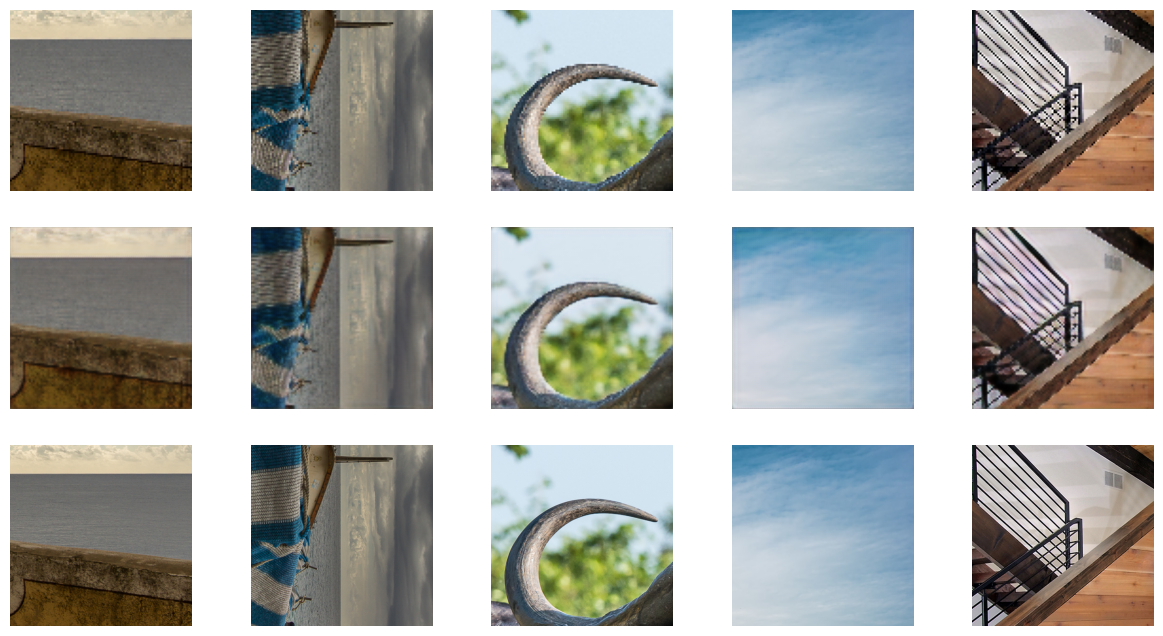

100%|██████████| 2729/2729 [04:23<00:00, 10.34it/s]


Epoch 2/734
L1 Loss: 0.02506


100%|██████████| 2729/2729 [04:23<00:00, 10.34it/s]


Epoch 3/734
L1 Loss: 0.02361


100%|██████████| 2729/2729 [04:23<00:00, 10.36it/s]


Epoch 4/734
L1 Loss: 0.02291


100%|██████████| 2729/2729 [04:24<00:00, 10.33it/s]


Epoch 5/734
L1 Loss: 0.02238


100%|██████████| 2729/2729 [04:24<00:00, 10.32it/s]


Epoch 6/734
L1 Loss: 0.02203


100%|██████████| 2729/2729 [04:24<00:00, 10.33it/s]


Epoch 7/734
L1 Loss: 0.02172


100%|██████████| 2729/2729 [04:24<00:00, 10.33it/s]


Epoch 8/734
L1 Loss: 0.02141


100%|██████████| 2729/2729 [04:24<00:00, 10.32it/s]


Epoch 9/734
L1 Loss: 0.02125


100%|██████████| 2729/2729 [04:24<00:00, 10.31it/s]


Epoch 10/734
L1 Loss: 0.02107


100%|██████████| 2729/2729 [04:24<00:00, 10.31it/s]


Epoch 11/734
L1 Loss: 0.02089


100%|██████████| 2729/2729 [04:24<00:00, 10.30it/s]


Epoch 12/734
L1 Loss: 0.02076


100%|██████████| 2729/2729 [04:24<00:00, 10.33it/s]


Epoch 13/734
L1 Loss: 0.02066


100%|██████████| 2729/2729 [04:23<00:00, 10.34it/s]


Epoch 14/734
L1 Loss: 0.02056


100%|██████████| 2729/2729 [04:23<00:00, 10.36it/s]


Epoch 15/734
L1 Loss: 0.02041


100%|██████████| 2729/2729 [04:23<00:00, 10.35it/s]


Epoch 16/734
L1 Loss: 0.02033


100%|██████████| 2729/2729 [04:23<00:00, 10.35it/s]


Epoch 17/734
L1 Loss: 0.02027


100%|██████████| 2729/2729 [04:23<00:00, 10.35it/s]


Epoch 18/734
L1 Loss: 0.02015


100%|██████████| 2729/2729 [04:23<00:00, 10.34it/s]


Epoch 19/734
L1 Loss: 0.02010


100%|██████████| 2729/2729 [04:24<00:00, 10.33it/s]


Epoch 20/734
L1 Loss: 0.02001


100%|██████████| 2729/2729 [04:24<00:00, 10.33it/s]


Epoch 21/734
L1 Loss: 0.01992


100%|██████████| 2729/2729 [04:24<00:00, 10.33it/s]


Epoch 22/734
L1 Loss: 0.01989


100%|██████████| 2729/2729 [04:23<00:00, 10.34it/s]


Epoch 23/734
L1 Loss: 0.01976


100%|██████████| 2729/2729 [04:24<00:00, 10.32it/s]


Epoch 24/734
L1 Loss: 0.01975


100%|██████████| 2729/2729 [04:24<00:00, 10.30it/s]


Epoch 25/734
L1 Loss: 0.01966


100%|██████████| 2729/2729 [04:24<00:00, 10.32it/s]


Epoch 26/734
L1 Loss: 0.01960


100%|██████████| 2729/2729 [04:24<00:00, 10.31it/s]


Epoch 27/734
L1 Loss: 0.01955


100%|██████████| 2729/2729 [04:24<00:00, 10.32it/s]


Epoch 28/734
L1 Loss: 0.01950


100%|██████████| 2729/2729 [04:24<00:00, 10.33it/s]


Epoch 29/734
L1 Loss: 0.01945


100%|██████████| 2729/2729 [04:24<00:00, 10.31it/s]


Epoch 30/734
L1 Loss: 0.01940


100%|██████████| 2729/2729 [04:24<00:00, 10.33it/s]


Epoch 31/734
L1 Loss: 0.01934


100%|██████████| 2729/2729 [04:24<00:00, 10.31it/s]


Epoch 32/734
L1 Loss: 0.01932


100%|██████████| 2729/2729 [04:24<00:00, 10.32it/s]


Epoch 33/734
L1 Loss: 0.01924


100%|██████████| 2729/2729 [04:23<00:00, 10.34it/s]


Epoch 34/734
L1 Loss: 0.01920


100%|██████████| 2729/2729 [04:23<00:00, 10.35it/s]


Epoch 35/734
L1 Loss: 0.01916


100%|██████████| 2729/2729 [04:25<00:00, 10.30it/s]


Epoch 36/734
L1 Loss: 0.01914


100%|██████████| 2729/2729 [04:24<00:00, 10.30it/s]


Epoch 37/734
L1 Loss: 0.01911


100%|██████████| 2729/2729 [04:25<00:00, 10.30it/s]


Epoch 38/734
L1 Loss: 0.01906


100%|██████████| 2729/2729 [04:25<00:00, 10.30it/s]


Epoch 39/734
L1 Loss: 0.01906


100%|██████████| 2729/2729 [04:24<00:00, 10.30it/s]


Epoch 40/734
L1 Loss: 0.01905


100%|██████████| 2729/2729 [04:25<00:00, 10.30it/s]


Epoch 41/734
L1 Loss: 0.01896


100%|██████████| 2729/2729 [04:25<00:00, 10.29it/s]


Epoch 42/734
L1 Loss: 0.01893


100%|██████████| 2729/2729 [04:24<00:00, 10.31it/s]


Epoch 43/734
L1 Loss: 0.01890


100%|██████████| 2729/2729 [04:25<00:00, 10.29it/s]


Epoch 44/734
L1 Loss: 0.01888


100%|██████████| 2729/2729 [04:25<00:00, 10.29it/s]


Epoch 45/734
L1 Loss: 0.01883


100%|██████████| 2729/2729 [04:25<00:00, 10.29it/s]


Epoch 46/734
L1 Loss: 0.01885


100%|██████████| 2729/2729 [04:25<00:00, 10.27it/s]


Epoch 47/734
L1 Loss: 0.01877


100%|██████████| 2729/2729 [04:24<00:00, 10.33it/s]


Epoch 48/734
L1 Loss: 0.01876


100%|██████████| 2729/2729 [04:24<00:00, 10.33it/s]


Epoch 49/734
L1 Loss: 0.01876


100%|██████████| 2729/2729 [04:24<00:00, 10.33it/s]


Epoch 50/734
L1 Loss: 0.01874


100%|██████████| 2729/2729 [04:24<00:00, 10.31it/s]


Epoch 51/734
L1 Loss: 0.01870

Epoch 51/734


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


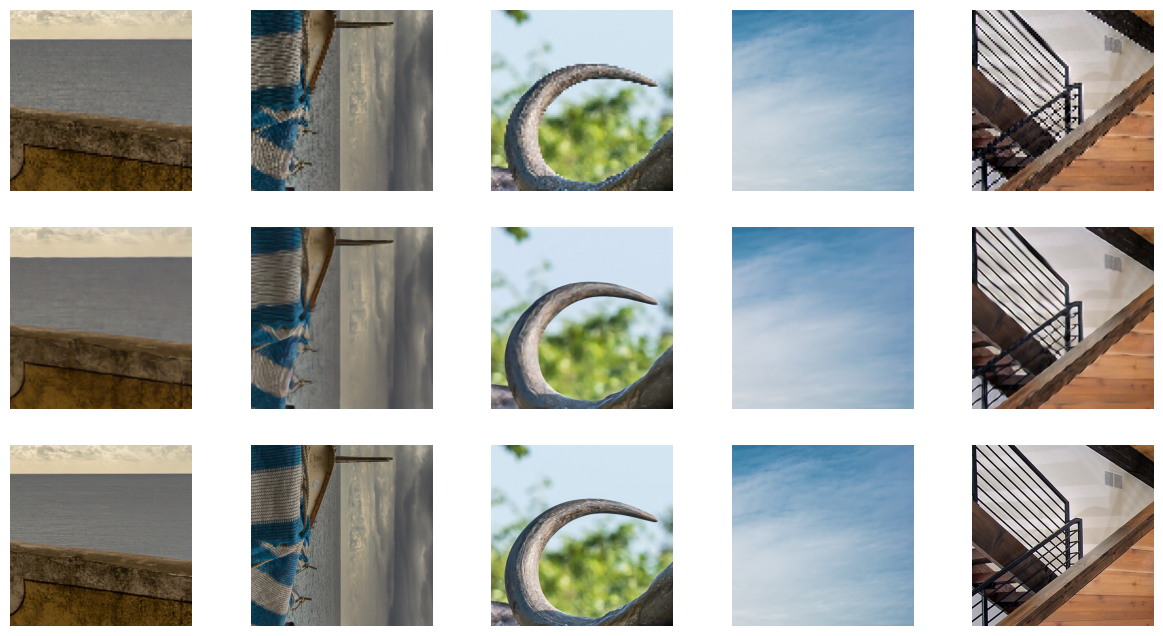

100%|██████████| 2729/2729 [04:24<00:00, 10.30it/s]


Epoch 52/734
L1 Loss: 0.01868


100%|██████████| 2729/2729 [04:24<00:00, 10.32it/s]


Epoch 53/734
L1 Loss: 0.01870


100%|██████████| 2729/2729 [04:24<00:00, 10.32it/s]


Epoch 54/734
L1 Loss: 0.01864


100%|██████████| 2729/2729 [04:24<00:00, 10.31it/s]


Epoch 55/734
L1 Loss: 0.01859


100%|██████████| 2729/2729 [04:24<00:00, 10.33it/s]


Epoch 56/734
L1 Loss: 0.01858


100%|██████████| 2729/2729 [04:24<00:00, 10.32it/s]


Epoch 57/734
L1 Loss: 0.01859


100%|██████████| 2729/2729 [04:24<00:00, 10.30it/s]


Epoch 58/734
L1 Loss: 0.01856


100%|██████████| 2729/2729 [04:24<00:00, 10.33it/s]


Epoch 59/734
L1 Loss: 0.01854


100%|██████████| 2729/2729 [04:24<00:00, 10.31it/s]


Epoch 60/734
L1 Loss: 0.01850


100%|██████████| 2729/2729 [04:24<00:00, 10.32it/s]


Epoch 61/734
L1 Loss: 0.01850


100%|██████████| 2729/2729 [04:24<00:00, 10.32it/s]


Epoch 62/734
L1 Loss: 0.01851


100%|██████████| 2729/2729 [04:24<00:00, 10.32it/s]


Epoch 63/734
L1 Loss: 0.01844


100%|██████████| 2729/2729 [04:24<00:00, 10.31it/s]


Epoch 64/734
L1 Loss: 0.01846


100%|██████████| 2729/2729 [04:24<00:00, 10.32it/s]


Epoch 65/734
L1 Loss: 0.01840


100%|██████████| 2729/2729 [04:24<00:00, 10.32it/s]


Epoch 66/734
L1 Loss: 0.01840


100%|██████████| 2729/2729 [04:35<00:00,  9.91it/s]


Epoch 67/734
L1 Loss: 0.01837


100%|██████████| 2729/2729 [09:24<00:00,  4.83it/s]


Epoch 68/734
L1 Loss: 0.01837


100%|██████████| 2729/2729 [08:02<00:00,  5.66it/s]


Epoch 69/734
L1 Loss: 0.01837


100%|██████████| 2729/2729 [07:26<00:00,  6.12it/s]


Epoch 70/734
L1 Loss: 0.01835


100%|██████████| 2729/2729 [10:53<00:00,  4.18it/s]


Epoch 71/734
L1 Loss: 0.01836


  0%|          | 6/2729 [00:00<06:35,  6.88it/s]


KeyboardInterrupt: 

In [9]:
def train_model(model, train_dl, epochs, display_every=50):
    data = next(iter(test_loader)) # getting a batch for visualizing the model output after fixed intrvals
    step = 0
    for e in range(epochs):
        loss_meter_dict = create_loss_meters() # function returing a dictionary of objects to
        i = 0                                  # log the losses of the complete network
        for data in tqdm(train_dl):
            model.setup_input(data)
            model.optimize()
            update_losses(model, loss_meter_dict, count=data[0].size(0)) # function updating the log objects
            i += 1
            step += 8
            if(step>100000):
                step=0
                model.disc_schedule.step()
                model.gen_schedule.step()

        print(f"\nEpoch {e+1}/{epochs}")
        if e % display_every == 0:
            torch.save(model.state_dict(),f'epoch-{e+1}.pt')
            log_results(loss_meter_dict) # function to print out the losses
            visualize(model, data, save=False) # function displaying the model's outputs


def pretrain_generator(train_dl, opt, criterion, epochs,display_every=50):
    data = next(iter(test_loader))
    for e in range(epochs):
        loss_meter = AverageMeter()
        for x,y in tqdm(train_dl):
            x = x.to(device)
            y = y.to(device)
            model.generator.train()
            model.set_requires_grad(model.discriminator,False)
            optimizer.zero_grad()
            fake_hr = model.generator(x)
            #print(fake_hr.shape,y.shape)
            loss = criterion(fake_hr, y)
            
            loss.backward()
            optimizer.step()
            

            loss_meter.update(loss.item())

        print(f"Epoch {e + 1}/{epochs}")
        print(f"L1 Loss: {loss_meter.avg:.5f}")

        if e % display_every == 0:
            torch.save(model.state_dict(),f'pretrained_epoch-{e+1}.pt')
            print(f"\nEpoch {e+1}/{epochs}")
            visualize(model, data, save=False) # function displaying the model's outputs


criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.generator.parameters(), lr=0.0001)
pretrain_generator(train_loader, optimizer, criterion, 734)

In [10]:
#torch.save(model.state_dict(),'pretrained_epoch-71.pt')

In [ ]:
#torch.save(model.state_dict(),'pretrained_epoch-166.pt')

In [ ]:
#model.load_state_dict(torch.load('pretrained_epoch-20.pt'))

In [8]:
def train_model(model, train_dl, epochs, display_every=1):
    data = next(iter(test_loader)) # getting a batch for visualizing the model output after fixed intrvals
    step = 0
    for e in range(epochs):
        loss_meter_dict = create_loss_meters() # function returing a dictionary of objects to
        i = 0                                  # log the losses of the complete network
        for data in tqdm(train_dl):
            model.setup_input(data)
            model.optimize()
            update_losses(model, loss_meter_dict, count=data[0].size(0)) # function updating the log objects
            i += 1
            step += 8
            if(step>100000):
                step=0
                model.disc_schedule.step()
                model.gen_schedule.step()

        print(f"\nEpoch {e+1}/{epochs}")
        if e % display_every == 0:
            torch.save(model.state_dict(),f'epoch-{e+1}.pt')
            log_results(loss_meter_dict) # function to print out the losses
            visualize(model, data, save=False) # function displaying the model's outputs


def pretrain_generator(train_dl, opt, criterion, epochs,display_every=1):
    data = next(iter(test_loader))
    for e in range(epochs):
        loss_meter = AverageMeter()
        for x,y in tqdm(train_dl):
            x = x.to(device)
            y = y.to(device)
            model.generator.train()
            model.set_requires_grad(model.discriminator,False)
            optimizer.zero_grad()
            fake_hr = model.generator(x)
            #print(fake_hr.shape,y.shape)
            loss = criterion(fake_hr, y)
            
            loss.backward()
            optimizer.step()
            

            loss_meter.update(loss.item())

        print(f"Epoch {e + 1}/{epochs}")
        print(f"L1 Loss: {loss_meter.avg:.5f}")

        if e % display_every == 0:
            torch.save(model.state_dict(),f'pretrained_epoch-{e+1}.pt')
            print(f"\nEpoch {e+1}/{epochs}")
            visualize(model, data, save=False) # function displaying the model's outputs


criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.generator.parameters(), lr=0.0001)
#pretrain_generator(train_loader, optimizer, criterion, 734)

In [10]:
model.load_state_dict(torch.load('./pretrained_epoch-71.pt'))

<All keys matched successfully>

100%|██████████| 2729/2729 [22:47<00:00,  2.00it/s]



Epoch 1/20
loss_D_fake: 0.23559
loss_D_real: 0.28154
loss_D: 0.25857
loss_G_GAN: 0.00234
loss_G_MSE: 0.02038
loss_G_Content: 0.00438
loss_G: 0.02710


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


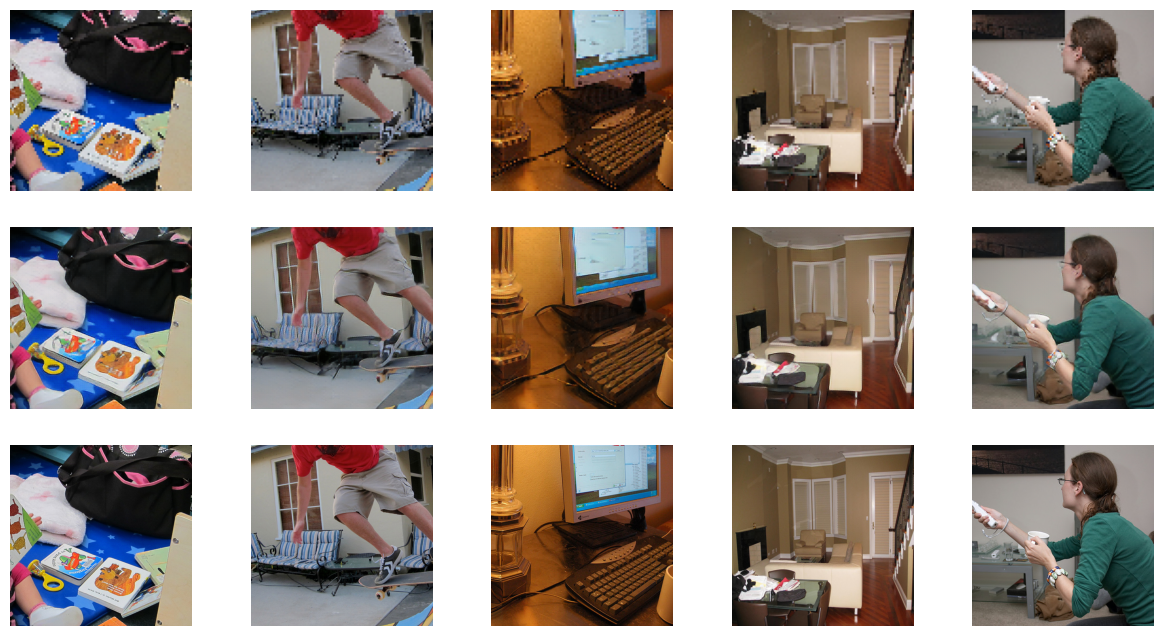

 29%|██▉       | 791/2729 [15:16<37:26,  1.16s/it]  


KeyboardInterrupt: 

In [11]:
train_model(model, train_loader, 20)